# Question Type Classification Baselines: (S)TF-IDF + Logistic Regression Control Experiments
#### Multilingual Question Type Classification and Complexity Prediction

In this notebook we will be developing a set of control baselines for question type classification using subword TF-IDF vectors generated with the text2text toolkit. The main goal of the notebook is to evaluate performance of ML classifers trained on TF-IDF vectors with shuffled/randomized labels.

##### Author: Robin Kokot
##### Date: March 2025


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Setup and Data Loading

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from datasets import load_dataset
from scipy.sparse import vstack
import wandb
import json
import logging
import time
import os
# ==================== Create output directories
models_dir = "/home/robin/Research/qtype-eval/scripts/experiments/models"
figures_dir = "/home/robin/Research/qtype-eval/scripts/experiments/figures"

# ==================== Set up displays

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

# ==================== Set up seed constant

SEED = 69
np.random.seed(SEED)

In [4]:
# ==================== Wandb config
run = wandb.init(project="MAIthesis", name="logreg-clf-baseline", tags=["logreg", "baseline", "question-classification", "tfidf"], job_type="model-training")

config = wandb.config
config.C = 1.0
config.solver = 'liblinear'
config.max_iter = 1000
config.random_state = 69
config.penalty = 'l2'

wandb.run.notes = "Baseline experiments with polar vs. content question type classification using Logistic Regression classifier on subword TF-IDF vectors, including tests with control labels"

In [8]:
# ==================== Dataset loading and label config
dataset = load_dataset("rokokot/question-type-and-complexity-v2")

y_train = np.array(dataset['train']['question_type'])    
y_dev = np.array(dataset['validation']['question_type'])
y_test= np.array(dataset['test']['question_type'])

print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Test label distribution: {np.bincount(y_test)}")
print(f"Validation label distribution: {np.bincount(y_dev)}")

langs_train = np.array(dataset['train']['language'])
langs_dev = np.array(dataset['validation']['language'])
langs_test = np.array(dataset['test']['language'])

Train label distribution: [3778 3682]
Test label distribution: [367 352]
Validation label distribution: [223 218]


In [9]:
destroyed_labels_path = "/home/robin/Research/qtype-eval/scripts/data/destroyed/destroyed_types/question_type_destroyed_seed_1.csv"
destroyed_df = pd.read_csv(destroyed_labels_path)

if "question_type" in destroyed_df.columns:
    y_train_shuffled = np.array(destroyed_df["question_type"])
    print(f"Successfully loaded destroyed labels from {destroyed_labels_path}")

Successfully loaded destroyed labels from /home/robin/Research/qtype-eval/scripts/data/destroyed/destroyed_types/question_type_destroyed_seed_1.csv


In [10]:
# ==================== TFIDF vectors loading
train_vectors = "/home/robin/Research/qtype-eval/scripts/data/vectors/tfidf_vectors_train.pkl"
dev_vectors = "/home/robin/Research/qtype-eval/scripts/data/vectors/tfidf_vectors_dev.pkl"
test_vectors = "/home/robin/Research/qtype-eval/scripts/data/vectors/tfidf_vectors_test.pkl"

with open(train_vectors, 'rb') as v:      
  X_train = pickle.load(v)
with open(dev_vectors, 'rb') as v:
  X_dev = pickle.load(v)
with open(test_vectors, 'rb') as v:
  X_test = pickle.load(v)

print("\nchecking shapes of features and labels:")
print(f"Train - Features: {X_train.shape[0]}, Labels: {y_train.shape[0]}")
print(f"Test - Features: {X_test.shape[0]}, Labels: {y_test.shape[0]}")
print(f"Validation - Features: {X_dev.shape[0]}, Labels: {y_dev.shape[0]}")
    


checking shapes of features and labels:
Train - Features: 7460, Labels: 7460
Test - Features: 719, Labels: 719
Validation - Features: 441, Labels: 441


In [13]:
# ====================== Helper functions for data formatting
sparse_matrices = [matrix[0] for matrix in X_train]
X_train_stacked = vstack(sparse_matrices)

sparse_matrices = [matrix[0] for matrix in X_dev]
X_dev_stacked = vstack(sparse_matrices)

sparse_matrices_test = [matrix[0] for matrix in X_test]
X_test_stacked = vstack(sparse_matrices_test)

In [ ]:
# ==================== Logistic regression training
logreg_clf = LogisticRegression(C=config.C,solver=config.solver,max_iter=config.max_iter,random_state=config.random_state,penalty=config.penalty)

start_time = time.time()
logreg_clf.fit(X_train_stacked, y_train)
training_time = time.time() - start_time
print(f"Training took {training_time:.2f} seconds")
wandb.log({"training_time": training_time})

Training took 0.72 seconds


Dev Set: Accuracy = 0.8662, F1 Score = 0.8631
Confusion Matrix (Dev Set):
[[196  27]
 [ 32 186]]


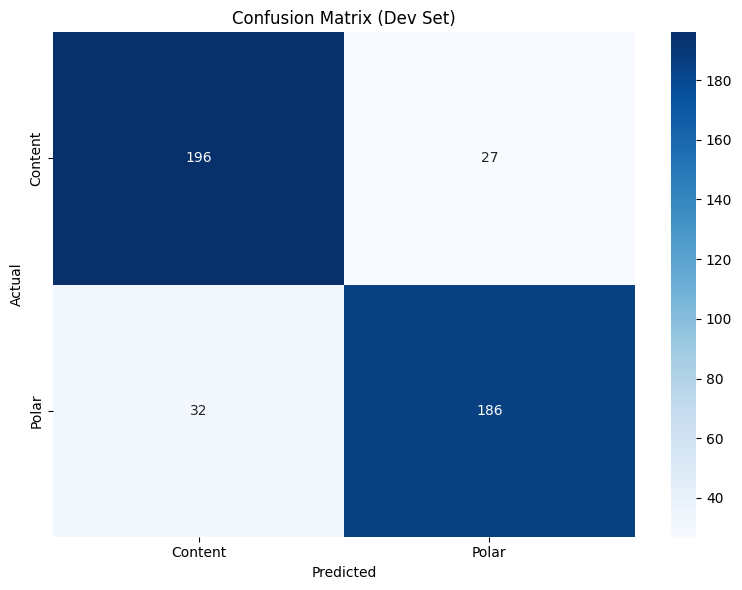

In [16]:
# ==================== evaluation on dev set
y_pred_dev = logreg_clf.predict(X_dev_stacked)
y_pred_proba_dev = logreg_clf.predict_proba(X_dev_stacked)[:, 1]

accuracy_dev = accuracy_score(y_dev, y_pred_dev)
precision_dev, recall_dev, f1_dev, _ = precision_recall_fscore_support(y_dev, y_pred_dev, average='binary')

print(f"Dev Set: Accuracy = {accuracy_dev:.4f}, F1 Score = {f1_dev:.4f}")

cm_dev = confusion_matrix(y_dev, y_pred_dev)
print("Confusion Matrix (Dev Set):")
print(cm_dev)

wandb.log({"dev_accuracy": accuracy_dev, "dev_precision": precision_dev, "dev_recall": recall_dev,"dev_f1": f1_dev})
plt.figure(figsize=(8, 6))

sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Polar'], yticklabels=['Content', 'Polar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Dev Set)')
plt.tight_layout()
wandb.log({"dev_confusion_matrix": wandb.Image(plt)})

Test Set: Accuracy = 0.7510, F1 Score = 0.7672
[[245 122]
 [ 57 295]]


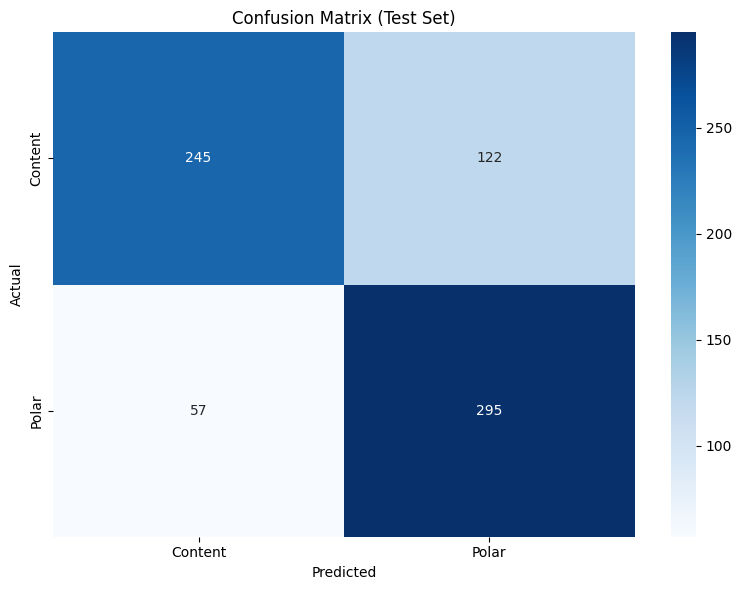

In [17]:
# ==================== evaluating on test set
y_pred_test = logreg_clf.predict(X_test_stacked)
y_pred_proba_test = logreg_clf.predict_proba(X_test_stacked)[:, 1]

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
print(f"Test Set: Accuracy = {accuracy_test:.4f}, F1 Score = {f1_test:.4f}")

cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)
wandb.log({"test_accuracy": accuracy_test,"test_precision": precision_test,"test_recall": recall_test,"test_f1": f1_test})
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Polar'], yticklabels=['Content', 'Polar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
wandb.log({"test_confusion_matrix": wandb.Image(plt)})

        feature_index  importance
14529           14529   12.193239
9007             9007    8.169691
86932           86932    7.946185
47503           47503    6.992776
1779             1779    6.722808
1996             1996    5.841316
34226           34226    5.294530
45841           45841    5.223389
43499           43499    5.137953
30858           30858    5.074517
66274           66274    4.979123
50560           50560    4.441785
57308           57308    4.304417
68756           68756    4.056063
40260           40260    3.894694
70539           70539    3.827484
101709         101709    3.767626
35346           35346    3.721026
10259           10259    3.712912
117               117    3.701396


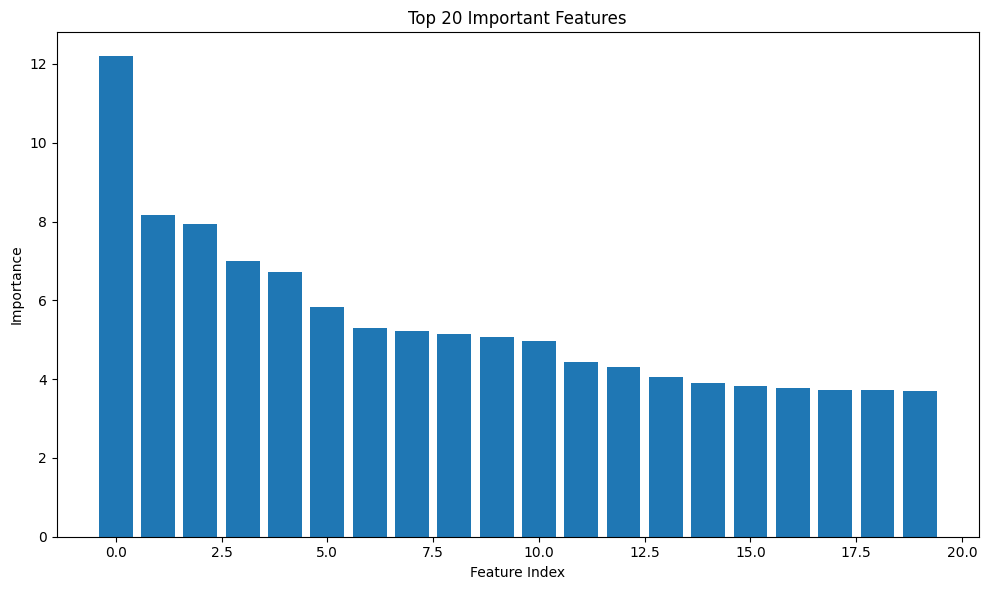

In [19]:
# ==================== Feature Importance Analysis
importance = np.abs(logreg_clf.coef_[0])
feature_importance_df = pd.DataFrame({'feature_index': range(len(importance)),'importance': importance}).sort_values('importance', ascending=False)

top_features = feature_importance_df.head(20)
print(top_features)

plt.figure(figsize=(10, 6))
plt.bar(range(20), top_features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
wandb.log({"feature_importance": wandb.Image(plt)})
wandb.log({"feature_importance_table": wandb.Table(data=[[int(idx), float(imp)] for idx, imp in zip(top_features['feature_index'], top_features['importance'])],columns=["feature_index", "importance"])})


In [ ]:
"""
# ==================== Load the token to index map for interpretation of the features
with open('/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/vectors/token_to_index_mapping.pkl', 'rb') as f:
    token_to_index = pickle.load(f)
with open('/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/vectors/idf_values.pkl', 'rb') as f:
    idf_values = pickle.load(f)

index_to_token = {idx: token for token, idx in token_to_index.items()}

top_indices = [86932, 14529, 1779, 545, 1996, 12432, 47503, 24, 177, 45841, 9007, 66274, 149, 67398, 121905, 121905, 1513, 16990, 3018, 117] # to do: fix this

top_features = []
for idx in top_indices:
    token = index_to_token.get(idx, f"Unknown-{idx}")
    idf = idf_values.get(idx, 0) if isinstance(idf_values, dict) else 0
    top_features.append((token, idx, idf))

print("Top tokens by importance:")
print("Token\t\tIndex\tIDF Value")
print("-" * 40)
for token, idx, idf in top_features:
    token_str = token if len(str(token)) < 8 else f"{token[:7]}..."
    print(f"{token_str:15} {idx:6d} {idf:.4f}")
"""

  language  samples  accuracy        f1  content_error_rate  polar_error_rate
0       ar       77  0.987013  0.976744            0.000000          0.045455
1       en      110  0.790909  0.792793            0.218182          0.200000
2       fi      110  0.845455  0.857143            0.236364          0.072727
3       id      110  0.572727  0.543689            0.363636          0.490909
4       ja       92  0.652174  0.741935            0.621622          0.163636
5       ko      110  0.663636  0.729927            0.581818          0.090909
6       ru      110  0.800000  0.833333            0.400000          0.000000


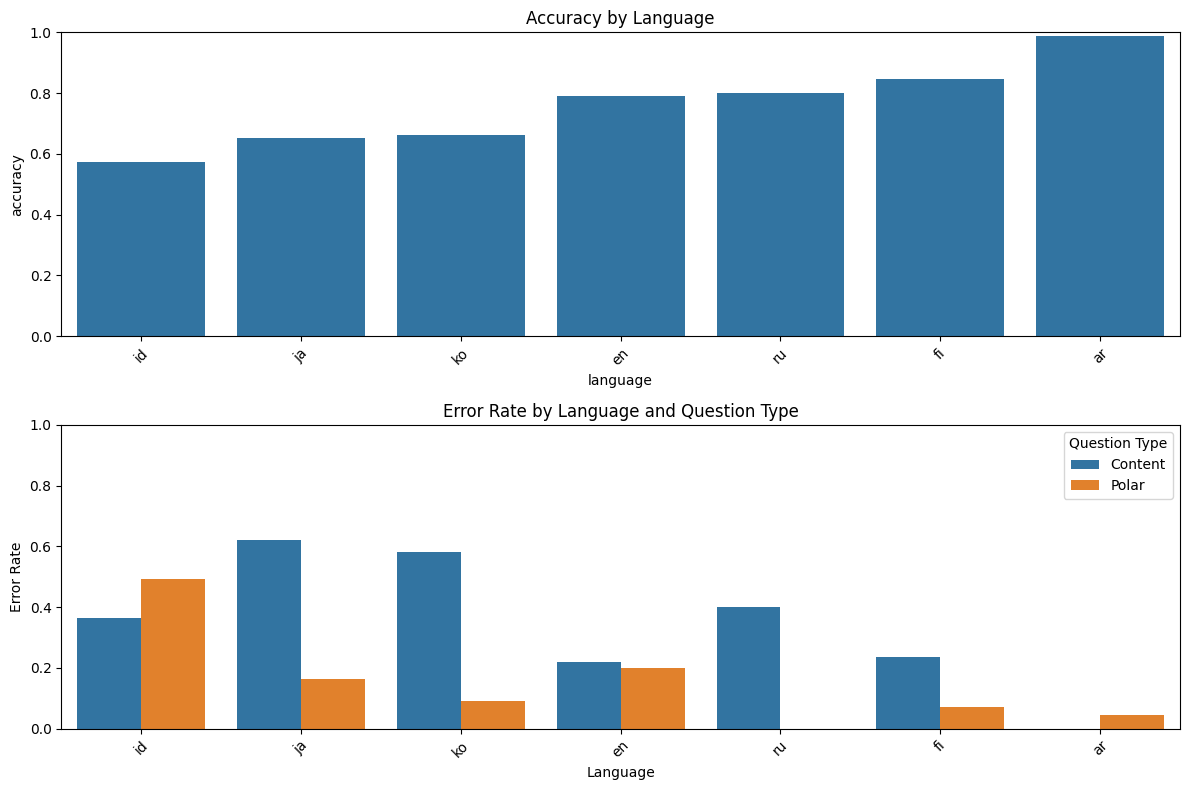

In [22]:
# ==================== analysis per language
def analyze_by_language(y_true, y_pred, languages):
    unique_langs = np.unique(languages)
    results = []
    
    for lang in unique_langs:
        lang_indices = languages == lang
            
        y_true_lang = y_true[lang_indices]
        y_pred_lang = y_pred[lang_indices]
        
        accuracy = accuracy_score(y_true_lang, y_pred_lang)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_lang, y_pred_lang, average='binary', zero_division=0)
        
        cm = confusion_matrix(y_true_lang, y_pred_lang)
        
        content_indices = y_true_lang == 0
        polar_indices = y_true_lang == 1
        
        content_error = 0 if sum(content_indices) == 0 else 1 - accuracy_score(y_true_lang[content_indices], y_pred_lang[content_indices])
        polar_error = 0 if sum(polar_indices) == 0 else 1 - accuracy_score(y_true_lang[polar_indices], y_pred_lang[polar_indices])
        
        results.append({'language': lang,'samples': sum(lang_indices),'accuracy': accuracy,'precision': precision,'recall': recall,'f1': f1,'content_error_rate': content_error,'polar_error_rate': polar_error,'confusion_matrix': cm})
    
    return pd.DataFrame(results)

language_results = analyze_by_language(y_test, y_pred_test, langs_test)
print(language_results[['language', 'samples', 'accuracy', 'f1', 'content_error_rate', 'polar_error_rate']])

plt.figure(figsize=(12, 8))
language_results = language_results.sort_values('accuracy', ascending=True)

plt.subplot(2, 1, 1)
sns.barplot(x='language', y='accuracy', data=language_results)
plt.xticks(rotation=45)
plt.title('Accuracy by Language')
plt.ylim(0, 1)

plt.subplot(2, 1, 2)
error_by_type = pd.DataFrame({'Language': np.concatenate([language_results['language'], language_results['language']]),'Question Type': ['Content'] * len(language_results) + ['Polar'] * len(language_results),'Error Rate': np.concatenate([language_results['content_error_rate'], language_results['polar_error_rate']])})
sns.barplot(x='Language', y='Error Rate', hue='Question Type', data=error_by_type)
plt.xticks(rotation=45)
plt.title('Error Rate by Language and Question Type')
plt.ylim(0, 1)

plt.tight_layout()
wandb.log({"language_performance": wandb.Image(plt)})

wandb.log({"language_performance_table": wandb.Table(data=language_results[['language', 'samples', 'accuracy', 'f1', 'content_error_rate', 'polar_error_rate']].values.tolist(),columns=['language', 'samples', 'accuracy', 'f1', 'content_error_rate', 'polar_error_rate'])})

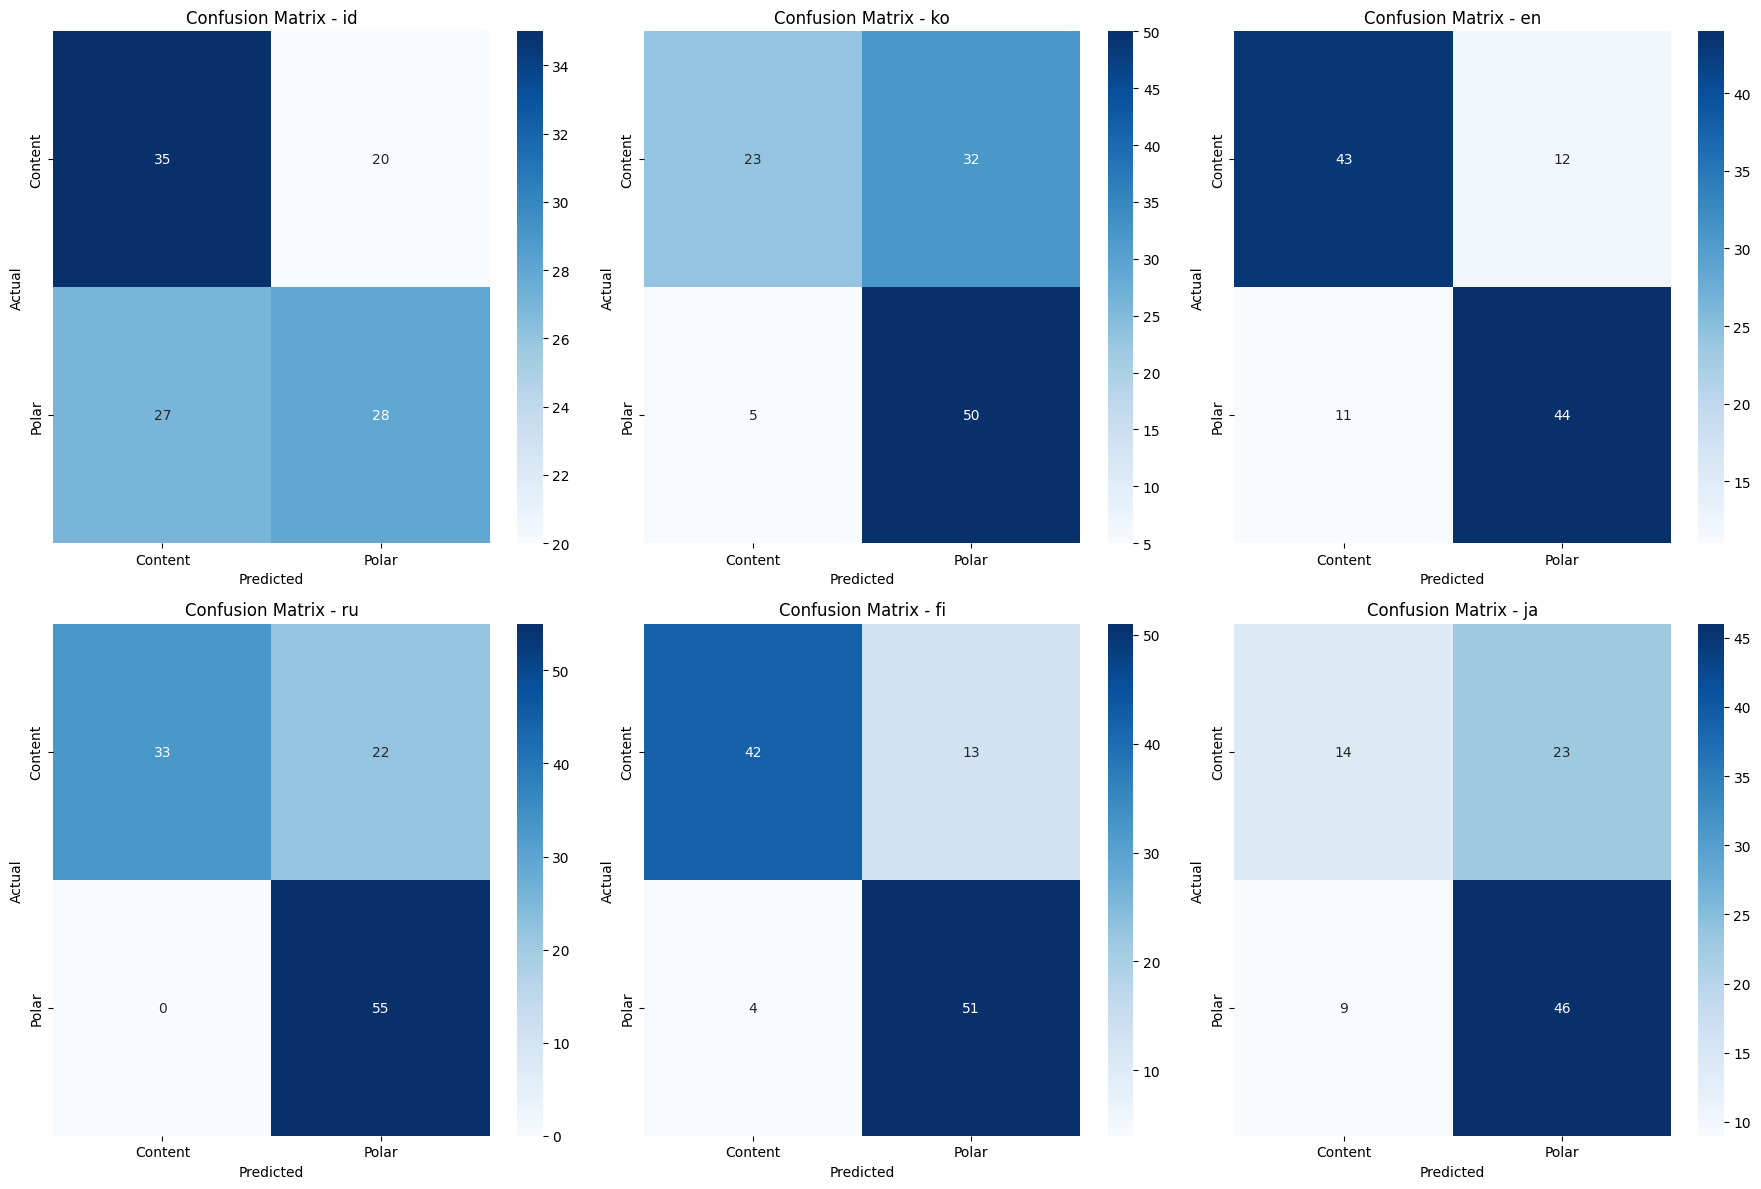

In [23]:
# ==================== Confusion matrices by language
top_langs = language_results.nlargest(6, 'samples')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (_, row) in enumerate(top_langs.iterrows()):
   
    lang = row['language']
    cm = row['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Content', 'Polar'],yticklabels=['Content', 'Polar'],ax=axes[i])

    axes[i].set_title(f'Confusion Matrix - {lang}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
wandb.log({"language_confusion_matrices": wandb.Image(plt)})

In [24]:
# ==================== Save Model
model_filename = os.path.join(models_dir, 'logreg_baseline_model.pkl')
with open(model_filename, 'wb') as f:
    pickle.dump(logreg_clf, f)
wandb.save(model_filename)

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/home/robin/Research/qtype-eval/scripts/experiments/baselines/wandb/run-20250327_205529-aiaj2h8e/files/models/logreg_baseline_model.pkl']

In [25]:
wandb.finish()

dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.86621
dev_f1,0.86311


## Experiments with control labels


In [27]:
# ==================== train loop for destroyed labels
def train_destroyed_label(seed, y_train_destroyed):
    wandb.init(project="MAIthesis",name=f"logreg-clf-baseline-control-seed-{seed}",tags=["baseline", "logistic-regression", "control-labels"],job_type="model-training",reinit=True)

    config = wandb.config
    config.C = 1.0
    config.solver = 'liblinear'
    config.max_iter = 1000
    config.random_state = 69
    config.penalty = 'l2'

    wandb.config.update({"model_type": "LogisticRegression","feature_type": "TF-IDF","label_type": f"destroyed-seed-{seed}","train_samples": X_train_stacked.shape[0],"test_samples": X_test_stacked.shape[0],"dev_samples": X_dev_stacked.shape[0],"feature_dim": X_train_stacked.shape[1]})

    logreg_clf = LogisticRegression(C=config.C,solver=config.solver,max_iter=config.max_iter,random_state=config.random_state,penalty=config.penalty)

    start_time = time.time()
    logreg_clf.fit(X_train_stacked, y_train_destroyed)
    training_time = time.time() - start_time
    print(f"Training took {training_time:.2f} seconds")
    wandb.log({"training_time": training_time})

    # ==================== Evaluate on dev set (real labels)
    y_pred_dev = logreg_clf.predict(X_dev_stacked)
    y_pred_proba_dev = logreg_clf.predict_proba(X_dev_stacked)[:, 1]
    accuracy_dev = accuracy_score(y_dev, y_pred_dev)
    precision_dev, recall_dev, f1_dev, _ = precision_recall_fscore_support(y_dev, y_pred_dev, average='binary')

    print(f"Dev Set: Accuracy = {accuracy_dev:.4f}, F1 Score = {f1_dev:.4f}")

    cm_dev = confusion_matrix(y_dev, y_pred_dev)
    print("Confusion Matrix (Dev Set):")
    print(cm_dev)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Polar'], yticklabels=['Content', 'Polar'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Dev Set (Destroyed Seed {seed})')
    plt.tight_layout()

    wandb.log({"dev_accuracy": accuracy_dev,"dev_precision": precision_dev,"dev_recall": recall_dev,"dev_f1": f1_dev})
    wandb.log({"dev_confusion_matrix": wandb.Image(plt)})

    # ==================== Evaluate on test set (real labels)
    y_pred_test = logreg_clf.predict(X_test_stacked)
    y_pred_proba_test = logreg_clf.predict_proba(X_test_stacked)[:, 1]

    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')

    print(f"Test Set: Accuracy = {accuracy_test:.4f}, F1 Score = {f1_test:.4f}")

    cm_test = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix (Test Set):")
    print(cm_test)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Polar'], yticklabels=['Content', 'Polar'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Test Set (Destroyed Seed {seed})')
    plt.tight_layout()

    wandb.log({"test_accuracy": accuracy_test,"test_precision": precision_test,"test_recall": recall_test,"test_f1": f1_test})
    wandb.log({"test_confusion_matrix": wandb.Image(plt)})

    model_path = os.path.join(models_dir, f'logreg_clf_destroyed_seed_{seed}_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(logreg_clf, f)
    wandb.save(model_path)

    importance = np.abs(logreg_clf.coef_[0])
    feature_importance_df = pd.DataFrame({'feature_index': range(len(importance)),'importance': importance}).sort_values('importance', ascending=False)
    top_features = feature_importance_df.head(20)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(20), top_features['importance'])
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Magnitude')
    plt.title(f'Top 20 Important Features (Destroyed Seed {seed})')
    plt.tight_layout()
    wandb.log({"feature_importance": wandb.Image(plt)})
    
    wandb.finish()

    return {'model': logreg_clf,'metrics': {'dev_accuracy': accuracy_dev,'dev_f1': f1_dev,'test_accuracy': accuracy_test,'test_f1': f1_test}}


Training model with destroyed labels (Seed 1)...
Loaded destroyed labels from /home/robin/Research/qtype-eval/scripts/data/destroyed/destroyed_types/question_type_destroyed_seed_1.csv
Original label distribution: [3778 3682]
Destroyed label distribution: [3778 3682]
Labels changed: 3696 (49.5%)


Training took 2.00 seconds
Dev Set: Accuracy = 0.5147, F1 Score = 0.4623
Confusion Matrix (Dev Set):
[[135  88]
 [126  92]]
Test Set: Accuracy = 0.4840, F1 Score = 0.4370
Confusion Matrix (Test Set):
[[204 163]
 [208 144]]


dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.51474
dev_f1,0.46231



Training model with destroyed labels (Seed 2)...
Loaded destroyed labels from /home/robin/Research/qtype-eval/scripts/data/destroyed/destroyed_types/question_type_destroyed_seed_2.csv
Original label distribution: [3778 3682]
Destroyed label distribution: [3778 3682]
Labels changed: 3744 (50.2%)


Training took 3.57 seconds
Dev Set: Accuracy = 0.4921, F1 Score = 0.4641
Confusion Matrix (Dev Set):
[[120 103]
 [121  97]]
Test Set: Accuracy = 0.4687, F1 Score = 0.4415
Confusion Matrix (Test Set):
[[186 181]
 [201 151]]


dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.49206
dev_f1,0.46411



Training model with destroyed labels (Seed 3)...
Loaded destroyed labels from /home/robin/Research/qtype-eval/scripts/data/destroyed/destroyed_types/question_type_destroyed_seed_3.csv
Original label distribution: [3778 3682]
Destroyed label distribution: [3778 3682]
Labels changed: 3670 (49.2%)


Training took 2.39 seconds
Dev Set: Accuracy = 0.5306, F1 Score = 0.5060
Confusion Matrix (Dev Set):
[[128  95]
 [112 106]]
Test Set: Accuracy = 0.5188, F1 Score = 0.5168
Confusion Matrix (Test Set):
[[188 179]
 [167 185]]


dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.53061
dev_f1,0.50597


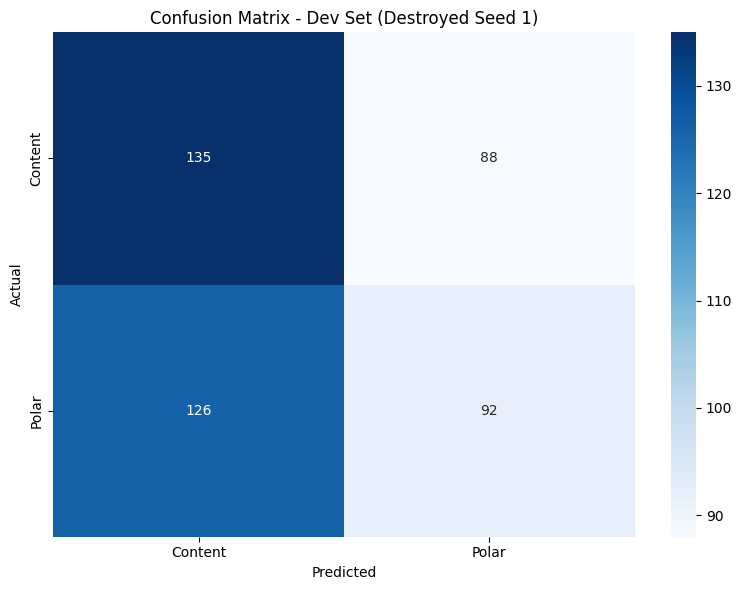

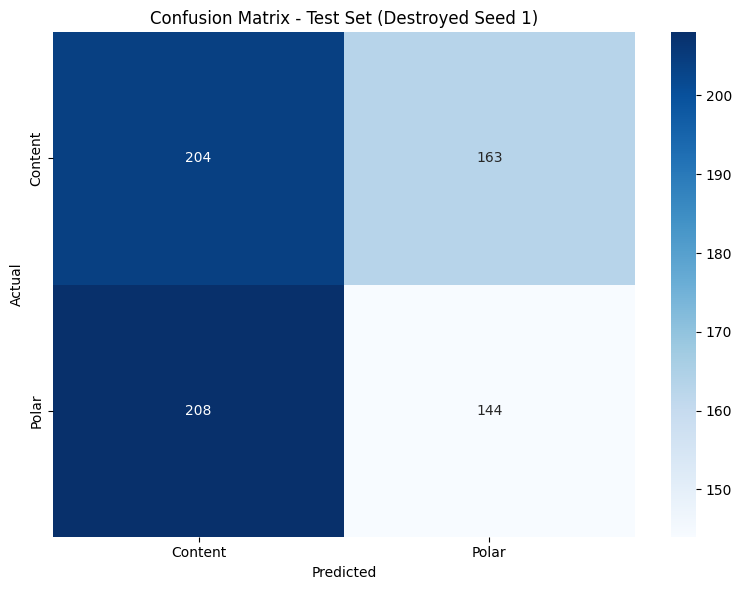

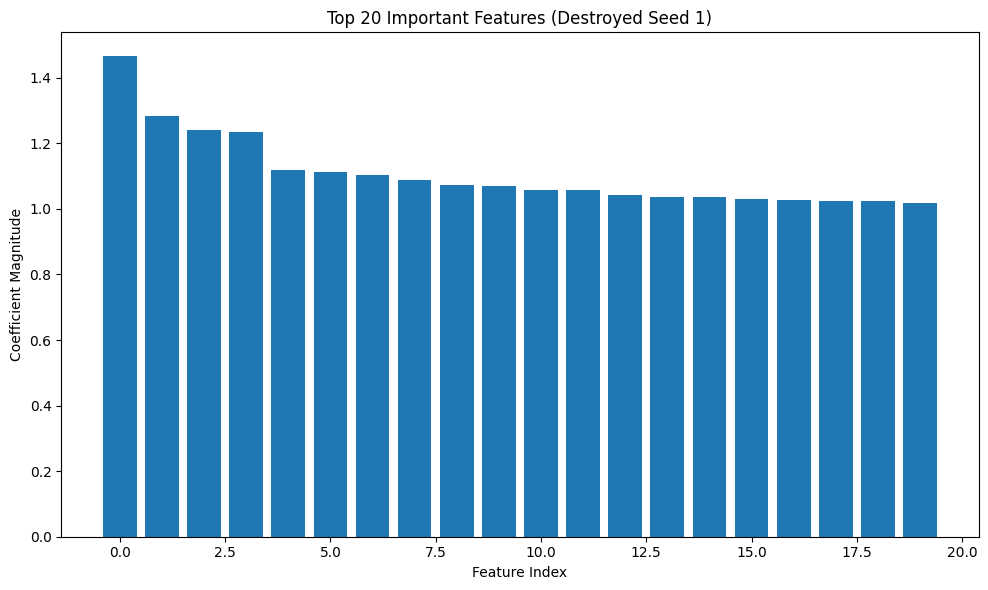

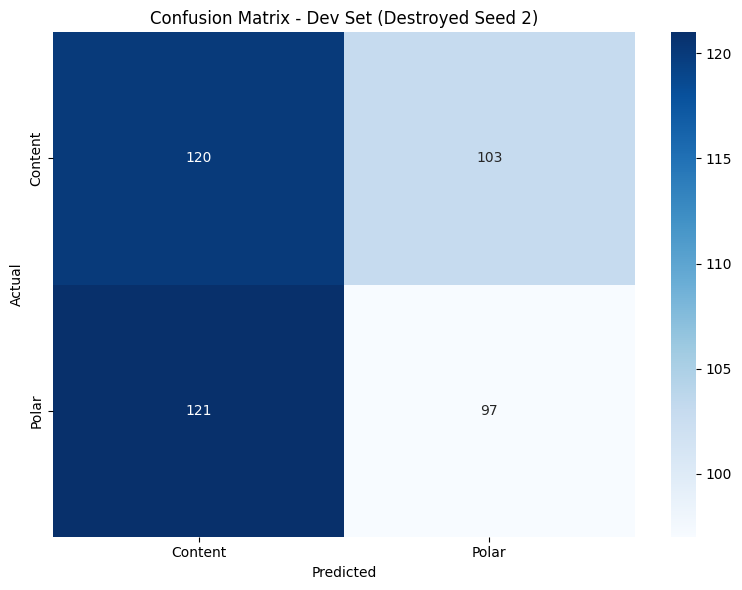

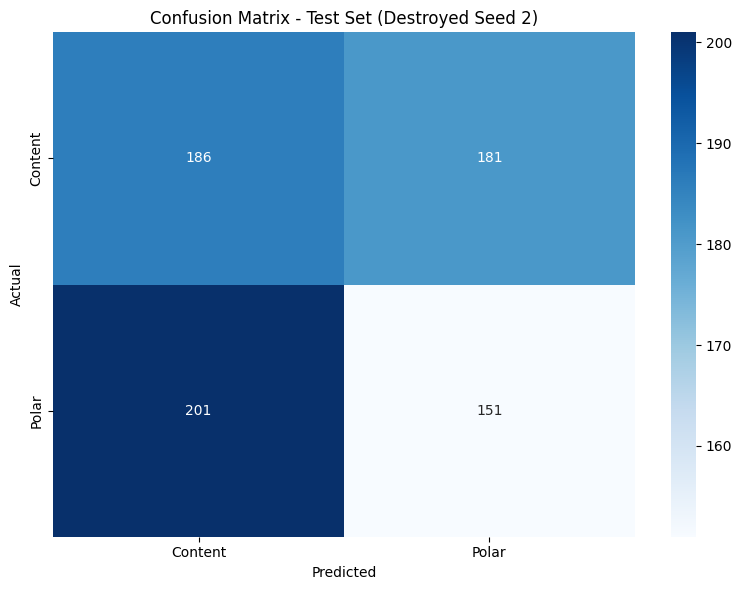

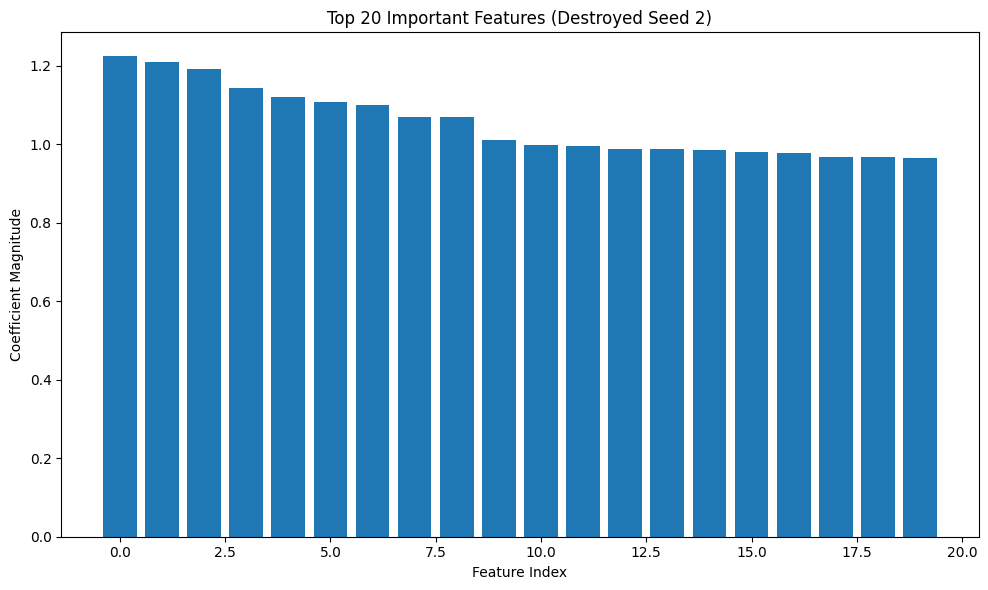

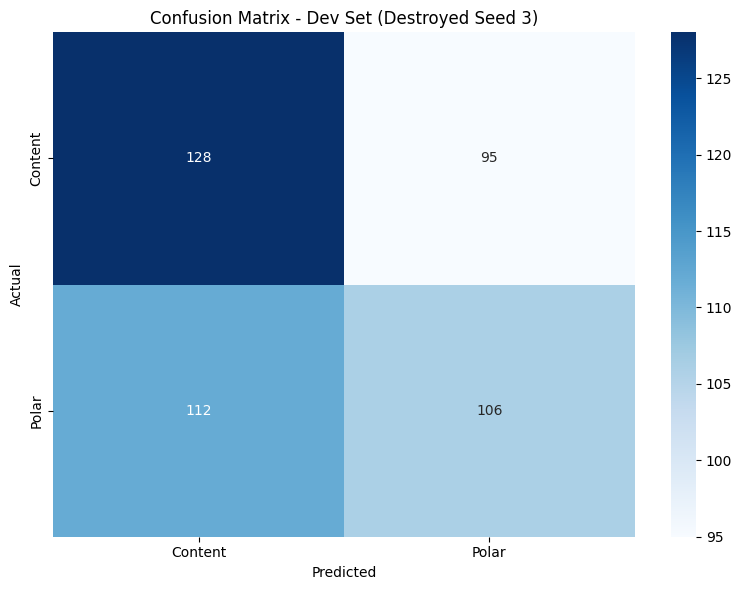

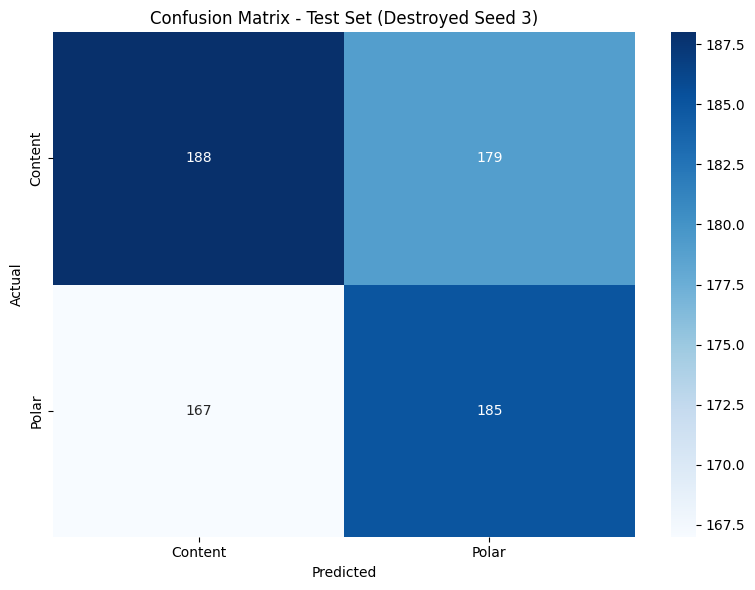

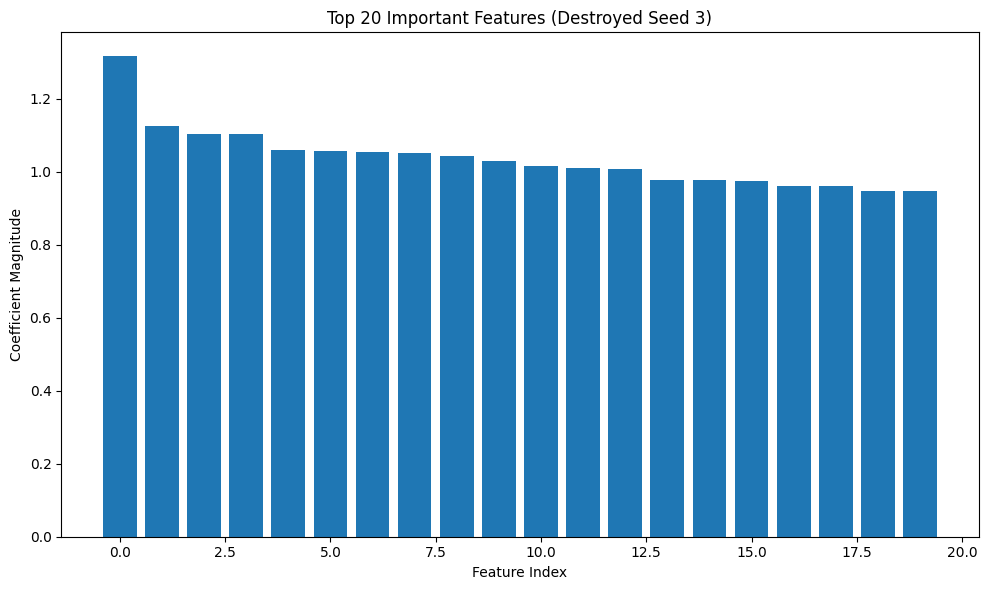

In [28]:
# ==================== Run the training loop for destroyed sets
results = {}
for seed in [1, 2, 3]:
    print(f"\nTraining model with destroyed labels (Seed {seed})...")
    destroyed_path = f"/home/robin/Research/qtype-eval/scripts/data/destroyed/destroyed_types/question_type_destroyed_seed_{seed}.csv"
    destroyed_df = pd.read_csv(destroyed_path)
    y_train_destroyed = np.array(destroyed_df['question_type_destroyed'])
    print(f"Loaded destroyed labels from {destroyed_path}")

    print(f"Original label distribution: {np.bincount(y_train)}")
    print(f"Destroyed label distribution: {np.bincount(y_train_destroyed)}")
    changed = np.sum(y_train != y_train_destroyed)
    print(f"Labels changed: {changed} ({changed/len(y_train)*100:.1f}%)")
    
    result = train_destroyed_label(seed, y_train_destroyed)
    results[seed] = result

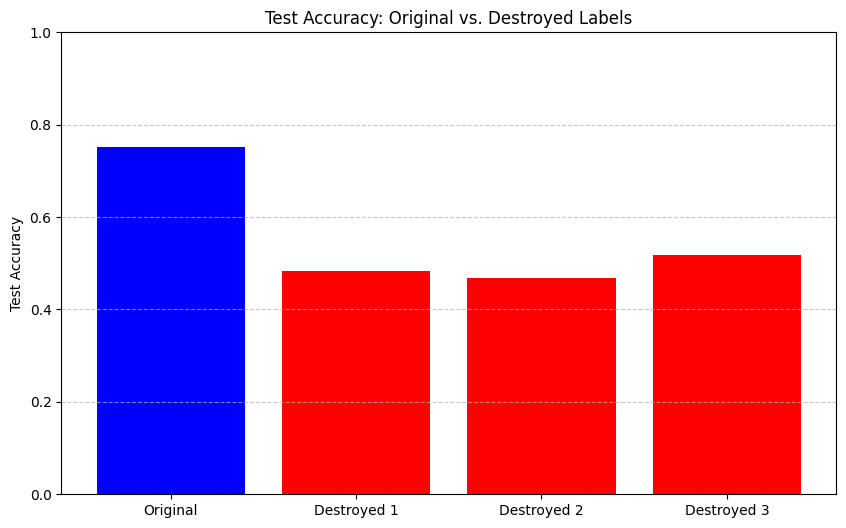

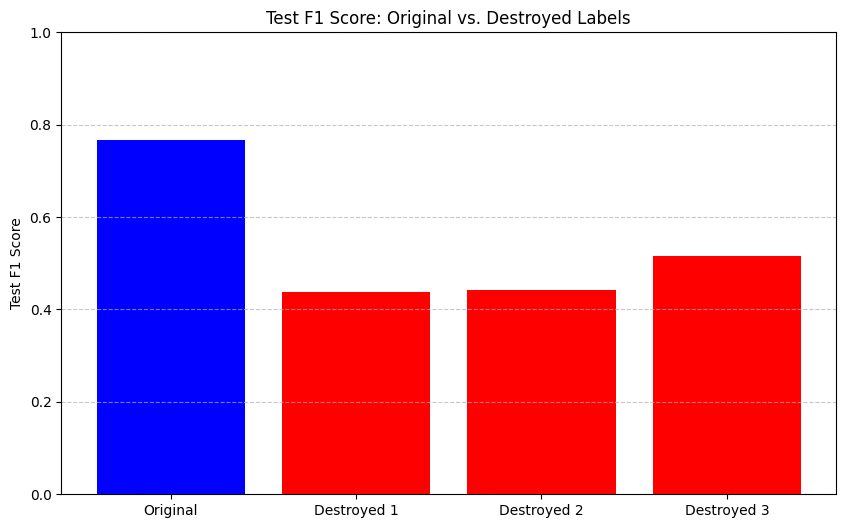

In [29]:
wandb.init(project="MAIthesis",name="logreg-control-comparison",tags=["baseline", "logistic-regression", "comparison"],job_type="analysis")
# =================== Plot performance stats for destroyed models on test labels
plt.figure(figsize=(10, 6))
models = ['Original'] + [f'Destroyed {seed}' for seed in [1, 2, 3]]
test_accuracies = [accuracy_test] + [results[seed]['metrics']['test_accuracy'] for seed in [1, 2, 3]]

plt.bar(models, test_accuracies, color=['blue'] + ['red']*3)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy: Original vs. Destroyed Labels')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

comparison_path = os.path.join(figures_dir, "logreg_test_accuracy_comparison.png")
plt.savefig(comparison_path)
wandb.log({"test_accuracy_comparison": wandb.Image(plt)})

plt.figure(figsize=(10, 6))
f1_scores = [f1_test] + [results[seed]['metrics']['test_f1'] for seed in [1, 2, 3]]

plt.bar(models, f1_scores, color=['blue'] + ['red']*3)
plt.ylabel('Test F1 Score')
plt.title('Test F1 Score: Original vs. Destroyed Labels')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

f1_comparison_path = os.path.join(figures_dir, "logreg_test_f1_comparison.png")
plt.savefig(f1_comparison_path)
wandb.log({"test_f1_comparison": wandb.Image(plt)})

comparison_metrics = {"original": {"dev_accuracy": float(accuracy_dev),"dev_f1": float(f1_dev),"test_accuracy": float(accuracy_test),"test_f1": float(f1_test)}}

for seed in [1, 2, 3]:
    comparison_metrics[f"destroyed_seed_{seed}"] = results[seed]['metrics']

combined_metrics_path = os.path.join(models_dir, "logreg_comparison_metrics.json")
with open(combined_metrics_path, 'w') as f:
    json.dump(comparison_metrics, f, indent=4)

# Create comparison table for wandb
comparison_table = wandb.Table(columns=["Model", "Test Accuracy", "Test F1"])
comparison_table.add_data("Original", accuracy_test, f1_test)

for seed in [1, 2, 3]:
    metrics = results[seed]['metrics']
    comparison_table.add_data(f"Destroyed {seed}", metrics['test_accuracy'], metrics['test_f1'])

wandb.log({"metrics_comparison": comparison_table})



Top 5 languages with biggest performance difference:
  language  samples_original  accuracy_original  accuracy_divergent  accuracy_diff
0       ar                77           0.987013            0.454545       0.532468
2       fi               110           0.845455            0.445455       0.400000
1       en               110           0.790909            0.427273       0.363636
6       ru               110           0.800000            0.445455       0.354545
5       ko               110           0.663636            0.436364       0.227273


<Figure size 1400x800 with 0 Axes>

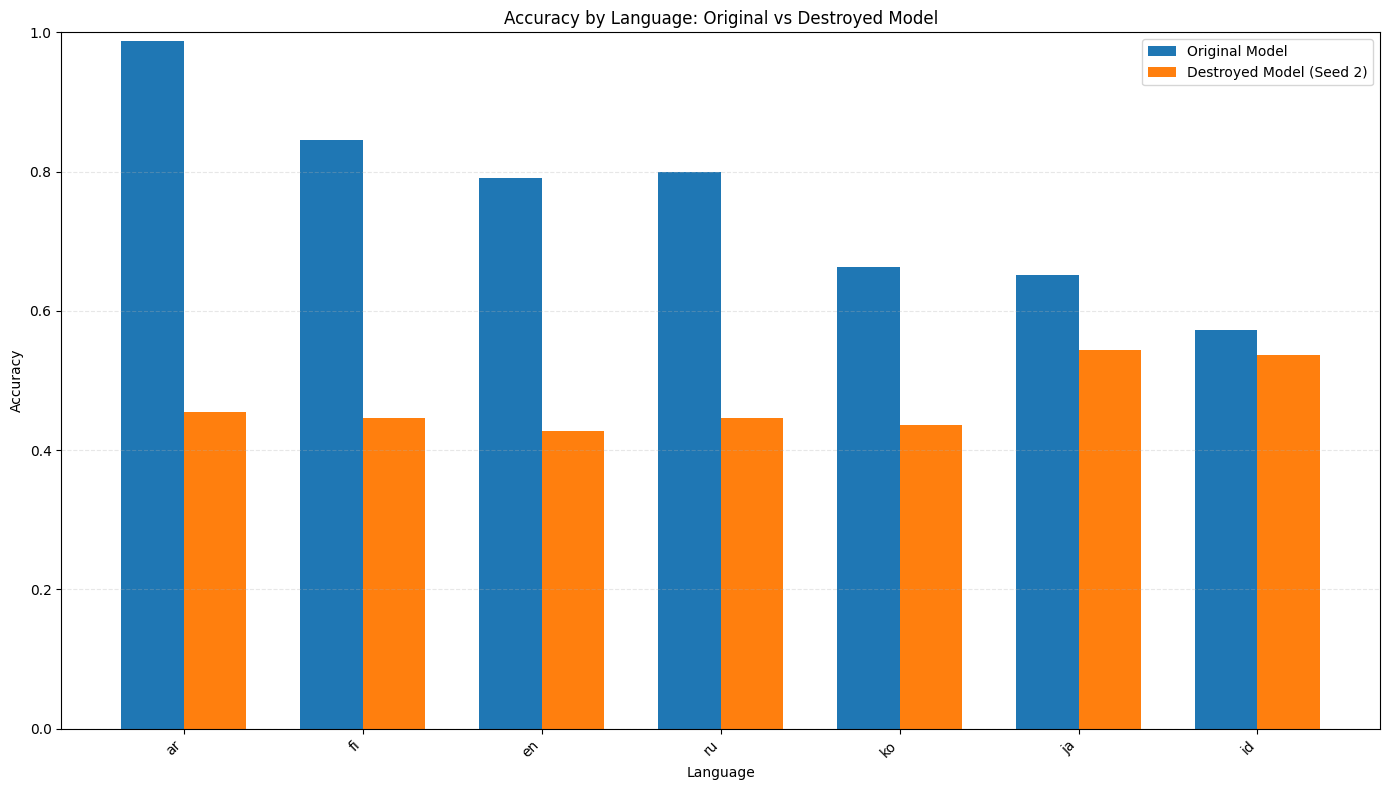

<Figure size 1400x1000 with 0 Axes>

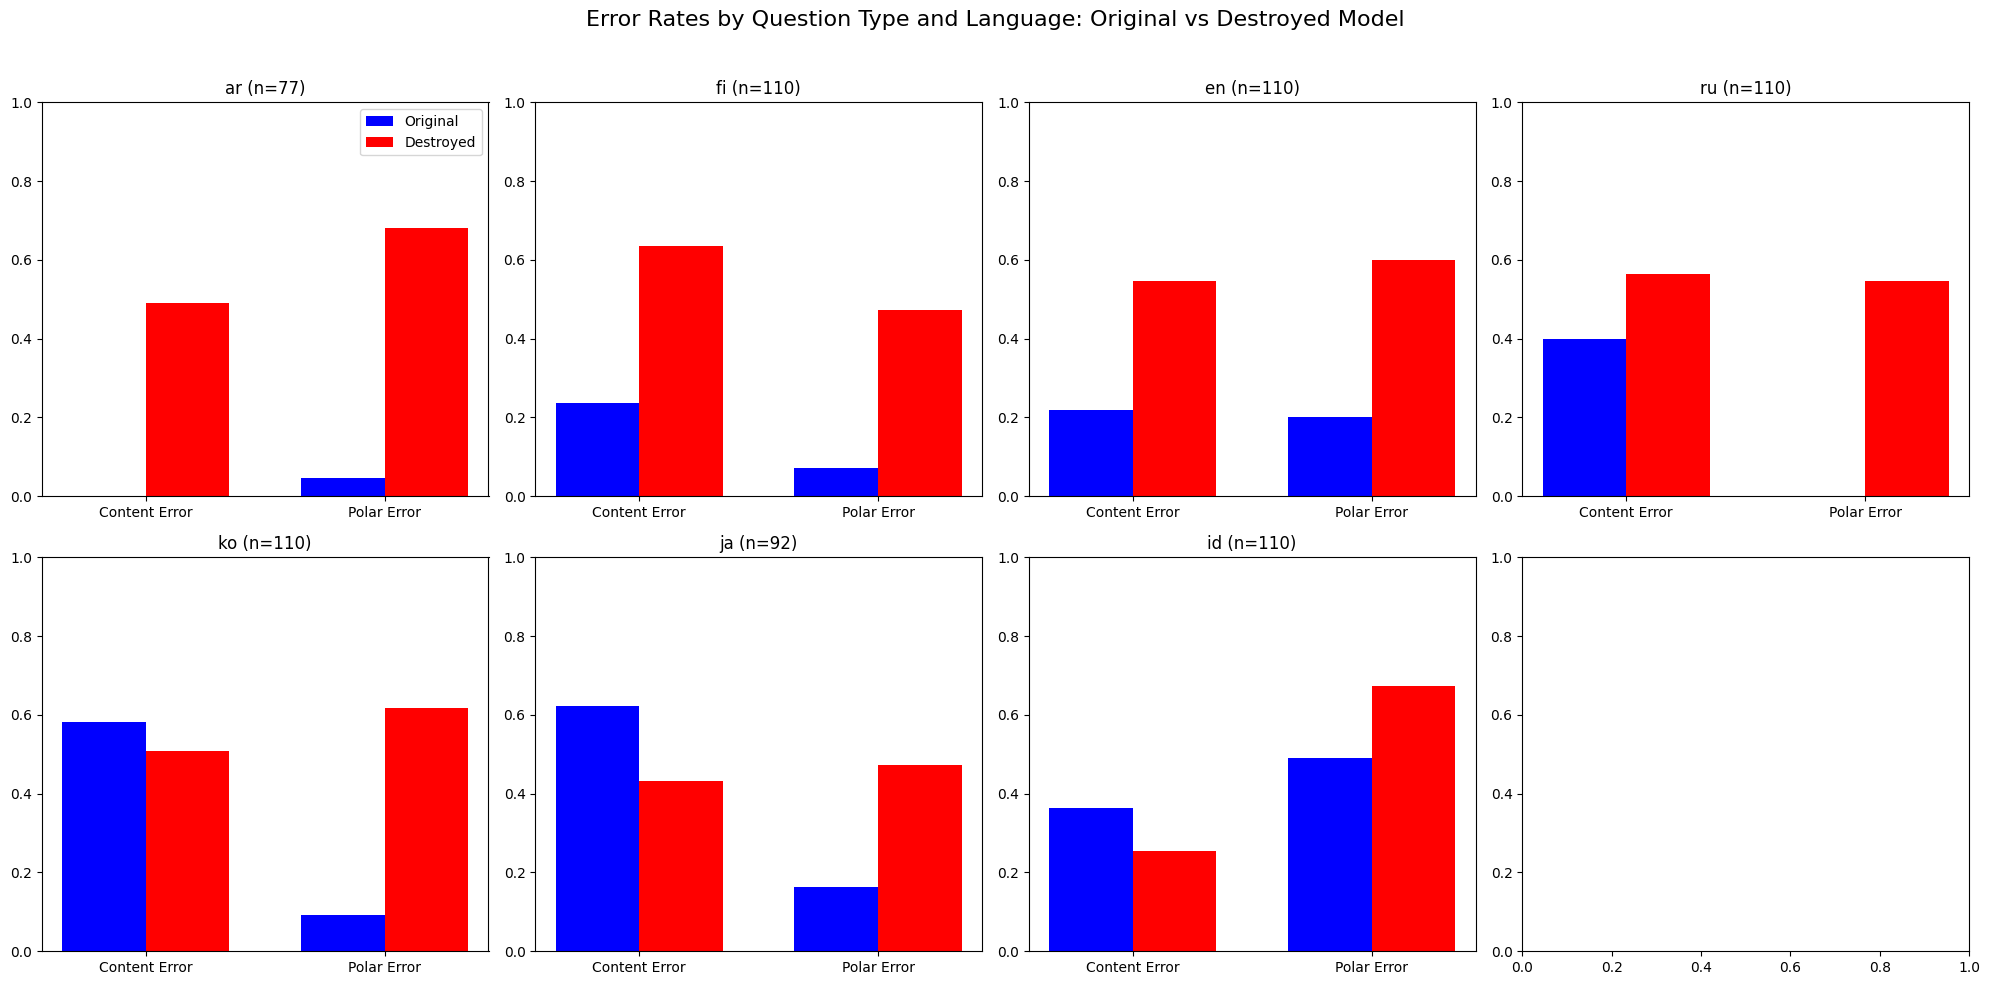

In [31]:
divergences = [(seed, abs(accuracy_test - results[seed]['metrics']['test_accuracy'])) for seed in [1, 2, 3]]
most_divergent_seed = sorted(divergences, key=lambda x: x[1], reverse=True)[0][0]
most_divergent_model = results[most_divergent_seed]['model']

def analyze_model_by_language(model, X, y_true, languages):
    unique_langs = np.unique(languages)
    results = []
    
    for lang in unique_langs:
        lang_indices = languages == lang

        X_lang = X[lang_indices]
        y_true_lang = y_true[lang_indices]
        y_pred_lang = model.predict(X_lang)
        
        accuracy = accuracy_score(y_true_lang, y_pred_lang)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_lang, y_pred_lang, average='binary', zero_division=0)
        
        content_indices = y_true_lang == 0
        polar_indices = y_true_lang == 1
        
        content_error = 0 if sum(content_indices) == 0 else 1 - accuracy_score(y_true_lang[content_indices], y_pred_lang[content_indices])
        polar_error = 0 if sum(polar_indices) == 0 else 1 - accuracy_score(y_true_lang[polar_indices], y_pred_lang[polar_indices])
        
        results.append({'language': lang,'samples': sum(lang_indices),'accuracy': accuracy,'f1': f1,'content_error_rate': content_error,'polar_error_rate': polar_error})
    
    return pd.DataFrame(results)

original_lang_results = analyze_model_by_language(logreg_clf, X_test_stacked, y_test, langs_test)

divergent_lang_results = analyze_model_by_language(most_divergent_model, X_test_stacked, y_test, langs_test)

combined_lang_results = pd.merge(original_lang_results,divergent_lang_results,on='language',suffixes=('_original', '_divergent'))

combined_lang_results['accuracy_diff'] = combined_lang_results['accuracy_original'] - combined_lang_results['accuracy_divergent']

combined_lang_results = combined_lang_results.sort_values('accuracy_diff', ascending=False)

# Print top 5 languages with biggest performance difference
print("\nTop 5 languages with biggest performance difference:")
print(combined_lang_results[['language', 'samples_original', 'accuracy_original', 'accuracy_divergent', 'accuracy_diff']].head(5))

plt.figure(figsize=(14, 8))
top_langs = combined_lang_results.head(10)['language'].values

filtered_data = combined_lang_results[combined_lang_results['language'].isin(top_langs)]

x = np.arange(len(top_langs))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bar1 = ax.bar(x - width/2, filtered_data['accuracy_original'], width, label='Original Model')
bar2 = ax.bar(x + width/2, filtered_data['accuracy_divergent'], width, label=f'Destroyed Model (Seed {most_divergent_seed})')

ax.set_ylim(0, 1)
ax.set_xlabel('Language')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Language: Original vs Destroyed Model')
ax.set_xticks(x)
ax.set_xticklabels(top_langs, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

fig.tight_layout()
language_comparison_path = os.path.join(figures_dir, "logreg_language_comparison.png")
plt.savefig(language_comparison_path)
wandb.log({"language_comparison": wandb.Image(fig)})

plt.figure(figsize=(14, 10))

top_diff_langs = combined_lang_results.head(7)['language'].values
filtered_diff_data = combined_lang_results[combined_lang_results['language'].isin(top_diff_langs)]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, lang in enumerate(top_diff_langs):
    if i >= 8:
        break
    lang_data = filtered_diff_data[filtered_diff_data['language'] == lang]
    
    x = np.arange(2)  
    width = 0.35
    
    content_error_orig = lang_data['content_error_rate_original'].values[0]
    content_error_dest = lang_data['content_error_rate_divergent'].values[0]
    polar_error_orig = lang_data['polar_error_rate_original'].values[0]
    polar_error_dest = lang_data['polar_error_rate_divergent'].values[0]
    
    axes[i].bar(x[0] - width/2, content_error_orig, width, label='Original', color='blue')
    axes[i].bar(x[0] + width/2, content_error_dest, width, label=f'Destroyed', color='red')
    axes[i].bar(x[1] - width/2, polar_error_orig, width, color='blue')
    axes[i].bar(x[1] + width/2, polar_error_dest, width, color='red')
    
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(['Content Error', 'Polar Error'])
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f'{lang} (n={int(lang_data["samples_original"].values[0])})')
    
    if i == 0:
        axes[i].legend()

plt.suptitle('Error Rates by Question Type and Language: Original vs Destroyed Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
error_rate_path = os.path.join(figures_dir, "logreg_error_rates_by_type.png")
plt.savefig(error_rate_path)
wandb.log({"error_rates_by_qtype": wandb.Image(plt)})

language_table = wandb.Table(columns=["Language", "Samples", "Acc (Original)", "Acc (Destroyed)", "Diff", "Content Err (Original)", "Content Err (Destroyed)", "Polar Err (Original)", "Polar Err (Destroyed)"])

for _, row in combined_lang_results.iterrows():
    language_table.add_data(row['language'],int(row['samples_original']),float(row['accuracy_original']),float(row['accuracy_divergent']),float(row['accuracy_diff']),float(row['content_error_rate_original']),float(row['content_error_rate_divergent']),float(row['polar_error_rate_original']),float(row['polar_error_rate_divergent']))

wandb.log({"language_performance_comparison": language_table})


In [32]:
# ==================== Create a comprehensive comparison table of all results
summary_table = pd.DataFrame({'Model': models,'Test Accuracy': test_accuracies,'Test F1 Score': f1_scores})

print("\nSummary of Results:")
print(summary_table)

summary_path = os.path.join(models_dir, "logreg_summary_results.csv")
summary_table.to_csv(summary_path, index=False)
print(f"Summary saved to {summary_path}")


print(f"Original model test accuracy: {accuracy_test:.4f}")
average_destroyed_acc = np.mean([results[seed]['metrics']['test_accuracy'] for seed in [1, 2, 3]])
print(f"Average destroyed model test accuracy: {average_destroyed_acc:.4f}")
print(f"Difference: {accuracy_test - average_destroyed_acc:.4f}")

for i, (_, row) in enumerate(combined_lang_results.head(3).iterrows()):
    print(f"  {row['language']}: Original acc = {row['accuracy_original']:.4f}, Destroyed acc = {row['accuracy_divergent']:.4f}, Diff = {row['accuracy_diff']:.4f}")

content_diff = combined_lang_results['content_error_rate_divergent'].mean() - combined_lang_results['content_error_rate_original'].mean()
polar_diff = combined_lang_results['polar_error_rate_divergent'].mean() - combined_lang_results['polar_error_rate_original'].mean()
print(f"  Content questions: Error increase = {content_diff:.4f}")
print(f"  Polar questions: Error increase = {polar_diff:.4f}")


Summary of Results:
         Model  Test Accuracy  Test F1 Score
0     Original       0.751043       0.767230
1  Destroyed 1       0.484006       0.437026
2  Destroyed 2       0.468707       0.441520
3  Destroyed 3       0.518776       0.516760
Summary saved to /home/robin/Research/qtype-eval/scripts/experiments/models/logreg_summary_results.csv
Original model test accuracy: 0.7510
Average destroyed model test accuracy: 0.4905
Difference: 0.2605
  ar: Original acc = 0.9870, Destroyed acc = 0.4545, Diff = 0.5325
  fi: Original acc = 0.8455, Destroyed acc = 0.4455, Diff = 0.4000
  en: Original acc = 0.7909, Destroyed acc = 0.4273, Diff = 0.3636
  Content questions: Error increase = 0.1444
  Polar questions: Error increase = 0.4286


In [33]:
wandb.finish()